In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
class MeanFieldVariationalMixtureDistribution(nn.Module):
    def __init__(self, proportions, components, device='cpu'):
        self.proportions = proportions
        self.components = components
        self.requires_grad_(False)
        
    def sample(self, n=1):
        d = torch.distributions.multinomial.Multinomial(n, self.proportions)
        m = d.sample()
        return torch.cat([self.components[c].sample(int(m[c])) for c in range(len(self.components))])
        
    def requires_grad_(self, b):
        self.proportions.requires_grad_(b) 
        for c in components:
            c.requires_grad_(b)
        
    def log_prob(self, x):
        return torch.logsumexp(torch.stack([torch.log(self.proportions[c]) + self.components[c].log_prob(x) for c in range(len(self.proportions))],dim=1),dim=1)
    
    def log_prob_augmented(self, x, q_new, unbounded_prop_new):
        prop_new = torch.sigmoid(unbounded_prop_new)
        A = torch.log(1-prop_new) + self.log_prob(x)
        B = torch.log(prop_new) + q_new.log_prob(x)
        return torch.logsumexp(torch.stack([A,B]),dim=0)

# Target density #

In [4]:
target_component = [torch.distributions.normal.Normal(-2.0, 0.5),
                    torch.distributions.normal.Normal(-4.0, 0.2),
                    torch.distributions.normal.Normal(-3.0, 0.9),
                    torch.distributions.normal.Normal(-2.5, 0.2),
                    torch.distributions.normal.Normal(-5, 0.6),]
target_proportions = torch.tensor([0.2, 0.35, 0.25, 0.05, 0.15])

In [5]:
def target(x):
    return torch.exp(logtarget(x))

def logtarget(x):
    logp = [None]*len(target_component)
    for j in range(len(target_component)):
        logp[j] = target_component[j].log_prob(x) + target_proportions[j].log()
    return torch.logsumexp(torch.cat(logp,dim=1),dim=1).unsqueeze(-1)

<IPython.core.display.Javascript object>


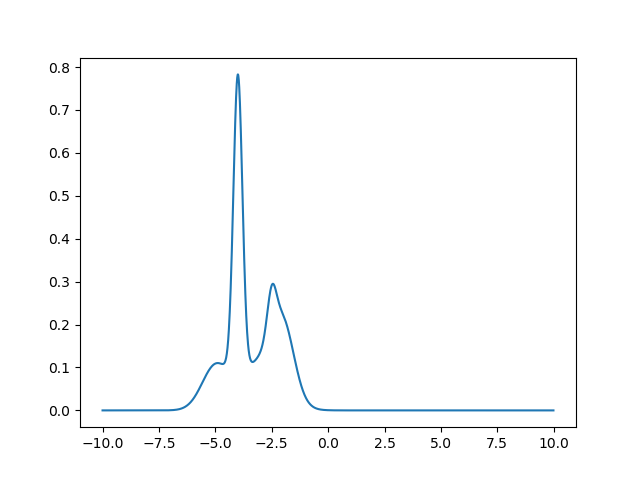

In [6]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())
plt.show()

# Variational Distribution #

In [7]:
q = MeanFieldVariationalDistribution(1)

In [8]:
q.mu.detach_().requires_grad_(True)
q.rho.detach_().requires_grad_(True);

In [9]:
n_samples_ELBO = 1000

In [10]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

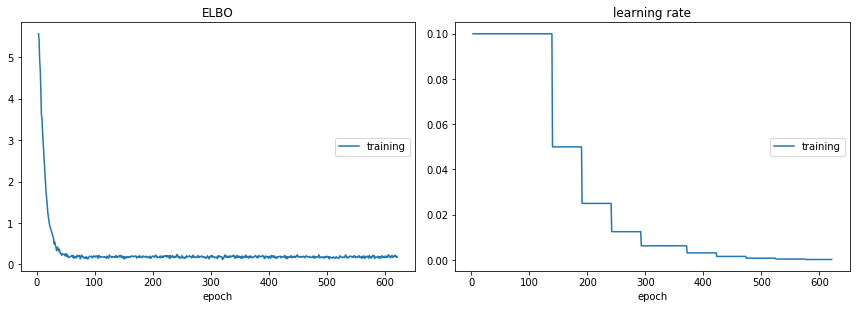

ELBO:
training   (min:    0.119, max:    6.467, cur:    0.176)

learning rate:
training   (min:    0.000, max:    0.100, cur:    0.000)


In [11]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logtarget(z)
    L = (LQ - LP).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        break

<IPython.core.display.Javascript object>


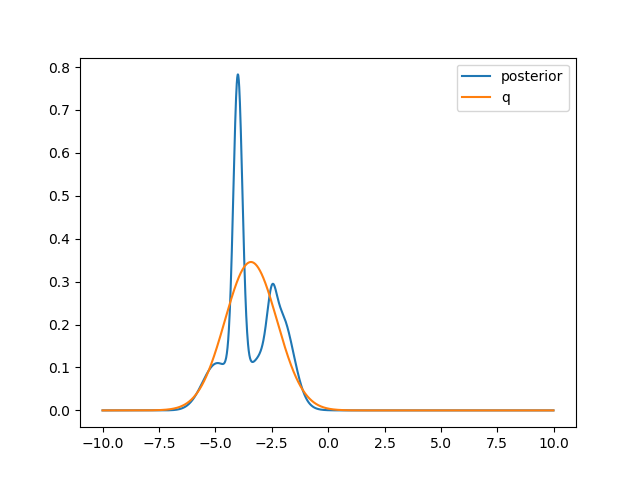

In [12]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())

plt.plot(x_lin.detach().numpy(), q.log_prob(x_lin).exp().detach().numpy())
plt.legend(['posterior', 'q'])
plt.show()

In [13]:
components = [q]
proportions = torch.tensor([1.0])
qC = MeanFieldVariationalMixtureDistribution(proportions, components)

In [14]:
def Boost(qC):    
    q_new = MeanFieldVariationalDistribution(1)
    unbounded_prop_new = torch.tensor(0.0).requires_grad_(True)

    q_new.set_mu(torch.distributions.Normal(loc=0.0,scale=5.0).sample())
    q_new.set_rho(torch.distributions.Normal(loc=2.0,scale=5.0).sample())

    nb_ELBO_samples = 10000

    optimizer = torch.optim.Adam(list(q_new.parameters())+[unbounded_prop_new], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.5)

    %matplotlib inline
    liveloss = PlotLosses()
    for t in range(10000):
        logs = {}
        optimizer.zero_grad()

        Xc = qC.sample(nb_ELBO_samples)
        Xnew = q_new.sample(nb_ELBO_samples)
        prop_new = torch.sigmoid(unbounded_prop_new)

        L = -(1-prop_new)*torch.mean(logtarget(Xc) - qC.log_prob_augmented(Xc, q_new, unbounded_prop_new)) - \
        prop_new*torch.mean(logtarget(Xnew) - qC.log_prob_augmented(Xnew, q_new, unbounded_prop_new))

        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        liveloss.update(logs)

        if t % 10 == 0:
            liveloss.draw()

        optimizer.step()

        if learning_rate < 0.0001:
            break

    components = qC.components + [q_new]
    proportions = torch.cat([(1-torch.sigmoid(unbounded_prop_new))*qC.proportions, torch.tensor([torch.sigmoid(unbounded_prop_new)])]).detach()

    qC = MeanFieldVariationalMixtureDistribution(proportions, components)
    return qC

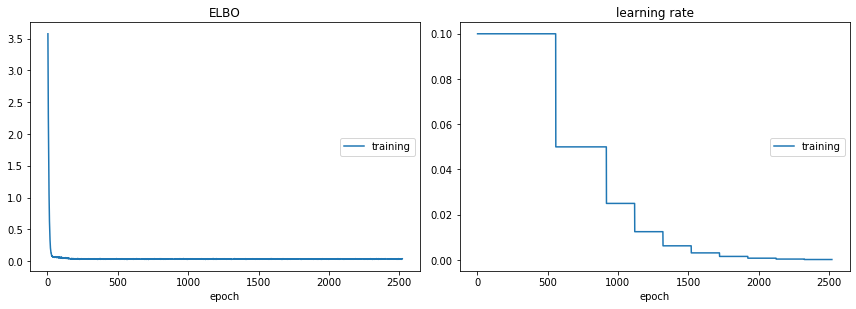

ELBO:
training   (min:    0.026, max:    4.642, cur:    0.036)

learning rate:
training   (min:    0.000, max:    0.100, cur:    0.000)


In [30]:
qC = Boost(qC)

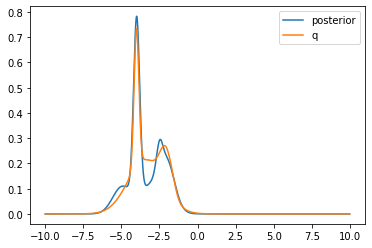

In [31]:
%matplotlib inline
%matplotlib inline

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())

plt.plot(x_lin.detach().numpy(), qC.log_prob(x_lin).exp().detach().numpy())
plt.legend(['posterior', 'q'])
plt.show()